# Using Mars Clock

This notebook shows how some of the basic functionality of Mars Clock works and how it can be used. We used the information from this website - https://www.giss.nasa.gov/tools/mars24/help/notes.html.

We also used notes from this website - https://marsclock.com/.

https://www.lpl.arizona.edu/~shane/publications/piqueux_etal_icarus_2015.pdf

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy.time import Time

In [4]:
# Define some constants
mars_solar_day = 24.*u.hour + 39.*u.minute + 35.244*u.second
mars_sol = mars_solar_day # This is what's referred to as a sol
mars_tropical_year_in_sols = 668.5921*mars_solar_day
mars_sidereal_day = 24.*u.hour + 37.*u.min + 22.663*u.second

mars_tropical_year = 668.5921*mars_sol
mars_sidereal_year = 668.5991*mars_sol

# J2000 epoch in Julian date
J2000 = Time('2000-01-01 12:00:00', scale='tt')
float_J2000 = J2000.jd # into a float
float_MJD_2000 = J2000.mjd # into a float

In [8]:
def calc_mars_sol_date(modified_julian_date):
    """
    Calculates Allison & McEwen's (2000) Mars sol-date (Eqn 32)
    
    Args:
        modified_julian_date (float or array of floats): Julian date - 2400000.5 (1873 December 29.5)
        
    Returns:
        Mars sol-date (float or array of floats)
    """
    
    k = 0.00096 # From https://marsclock.com/
    factor = Time("2000-01-06 00:00:00").mjd
    
    return modified_julian_date/(mars_sol/u.day) + factor - k

def calc_mars_coordinated_time(mars_sol_date):
    """
    Calculate Mars coordinated time (MTC)
    
    Args:
        mars_sol_date (float or array of floats): Mars sol-date as defined by Allison & McEwen (2000)
        
    Returns:
        Mars coordinated time (float)
    """
    
    return (24.*mars_sol_date) % 24

def calc_mean_anomaly(delta_J2000):
    """
    Returns the mean anomaly using Eq 16 from Allison & McEwen (2000) - 
    https://ui.adsabs.harvard.edu/abs/2000P%26SS...48..215A/abstract
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
        
    Returns:
        mean anomaly (float or array of floats in degrees)
    """
    
    M_0 = 19.3870 # degrees
    lin_coeff = 0.52402075 # degrees per day
    
    return M_0 + lin_coeff*delta_J2000 # From Table 2 in Allison & McEwen (2000)

def calc_alpha_FMS(delta_J2000, mod_360=True):
    """
    Returns the ficitious mean Sun angle using Eq 17 from Allison & McEwen (2000) - 
    https://ui.adsabs.harvard.edu/abs/2000P%26SS...48..215A/abstract
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
        mod_360 (bool, optional): take the modulus with 360 degrees
        
    Returns:
        ficitious mean Sun angle (float or array of floats in degrees)
    """
    
    alpha_0  = 270.3863 # degrees
    lin_coeff = 0.52403840 # degrees per day
    quad_coeff = -4e-13 # degrees per day per day
    
    alpha_FMS = alpha_0 + lin_coeff*delta_J2000 + quad_coeff*delta_J2000*delta_J2000
    
    if(mod_360):
        alpha_FMS = alpha_FMS % 360.
    
    return alpha_FMS

def calc_PBS(delta_J2000):
    """
    The planetary perturbation terms from Allison & McEwen (2000) - you probably don't need to call this!
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
    
    Returns:
        planetary perturbation terms (float or array of floats) from Eq 18
    """
    
    # amplitudes in degrees
    amplitudes = np.array([0.007, 0.006, 0.004, 0.004, 0.002, 0.002, 0.002])
    
    # years in centuries
    tau = np.array([2.2353, 2.7543, 1.1177, 15.7866, 2.1354, 2.4694, 32.8493])
    
    # phases in degrees to radians
    phi = np.array([49.409, 168.173, 191.837, 21.736, 15.704, 95.528, 49.095])
    
    # pre-prending factor that appears in Eq 18
    factor = 0.985626 # degrees
    
    PBS = np.zeros_like(delta_J2000)
    
    for i in range(len(amplitudes)):
        PBS += amplitudes[i]*np.cos((factor*delta_J2000/tau[i] + phi[i])*np.pi/180.)
    
    return PBS

def calc_Ls(delta_J2000, mod_360=True):
    """
    Calculate Mars' seasonal angle Ls using Eq 19 from Allison & McEwen (2000) - 
    https://ui.adsabs.harvard.edu/abs/2000P%26SS...48..215A/abstract
    
    Args:
        delta_J2000 (float or array of floats): Julian date difference between desired time and
        J2000 (2000 Jan 1 12:00:00)
        mod_360 (bool, optional): take the modulus with 360 degrees
    
    Returns:
        Mars' seasonal angle Ls
    
    """
    
    sin_M_const_factor = 10.691 # degrees
    sin_M_lin_factor = 3e-7 # degrees per day
    sin_2M_factor = 0.623 # degrees
    sin_3M_factor = 0.050 # degrees
    sin_4M_factor = 0.005 # degrees
    sin_5M_factor = 0.0005 # degrees
    
    mean_anomaly = calc_mean_anomaly(delta_J2000)*np.pi/180. # from degrees to radians
    sin_M = np.sin(mean_anomaly)
    sin_2M = np.sin(2.*mean_anomaly)
    sin_3M = np.sin(3.*mean_anomaly)
    sin_4M = np.sin(4.*mean_anomaly)
    sin_5M = np.sin(5.*mean_anomaly)
    
    alpha_FMS = calc_alpha_FMS(delta_J2000, mod_360=False)
    PBS = calc_PBS(delta_J2000)
    
    Ls = alpha_FMS + (sin_M_const_factor + sin_M_lin_factor*delta_J2000)*sin_M +\
       sin_2M_factor*sin_2M + sin_3M_factor*sin_3M + sin_4M_factor*sin_4M +\
       sin_5M_factor*sin_5M + PBS
    
    if(mod_360):
        Ls = Ls % 360.
        
    return Ls

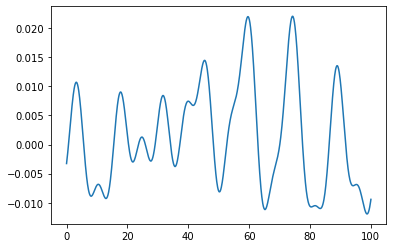

In [39]:
# Make pandas Timestamp
ts = Time('2021-02-18 20:55', scale='utc').mjd
msd = calc_mars_sol_date(ts)
mtc = calc_mars_coordinated_time(msd)

times = np.linspace(0., 100, 1000)
plt.plot(times, calc_PBS(times))

In [182]:
# Check that Ls at J2000 is the right value
# assert(np.isclose(calc_Ls(0.), 272.4366730652975))

# Ls = 0 dates given in https://www.lpl.arizona.edu/~shane/publications/piqueux_etal_icarus_2015.pdf

# Dates given on https://www.planetary.org/articles/mars-calendar
first_date_in_delta_J2000 = Time('1955-04-11 12:00:00', scale='utc').jd - float_J2000
print(calc_Ls(first_date_in_delta_J2000))

second_date = Time('1955-04-11 12:00:00', scale='utc').jd - float_J2000
print(calc_Ls(-15649.090))

# Perseverance_landing_datetime = Time("2021-02-18 20:44:00", scale='utc').jd# - float_J2000
# print(Perseverance_landing_datetime)

0.02173421466432046
0.0016495298978043138


In [10]:
InSight_first_sol = Time("2018-11-26 19:44:52", scale='utc')
InSight_first_sol_delta_JD = InSight_first_sol.jd - float_J2000
print(calc_Ls(InSight_first_sol_delta_JD))

295.65073701311576


In [11]:
Curiosity_first_sol = Time("2012-08-06 5:17:57", scale='utc')
Curiosity_first_sol_delta_JD = Curiosity_first_sol.jd - float_J2000
print(calc_Ls(Curiosity_first_sol_delta_JD))

150.7014666641744


In [18]:
date = Time(float_J2000 - 16336.050, format='jd')
print(date.fits)

1955-04-11T10:48:00.000


/Users/brian/opt/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
